In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import os
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


2024-09-26 10:11:42.550481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 10:11:42.626084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 10:11:42.644052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 10:11:42.794620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 10:11:44.108441: W tensorflow/compiler/tf2

### Defining functions

In [2]:
def generate_file_list():
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                file_list.append(file_path)
                labels.append(label)

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


import os
import random

def generate_file_list(limit_per_dir):
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        dir_files = []

        # Collect all files in the directory
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                dir_files.append(file_path)
        
        # Randomly select files up to the limit
        if len(dir_files) > limit_per_dir:
            selected_files = random.sample(dir_files, limit_per_dir)
        else:
            selected_files = dir_files
        
        # Append selected files and their labels
        file_list.extend(selected_files)
        labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels



def load_spectra(file_list, known_rows=None):
    spectra_data = []
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                spectra = hdul[0].data[0][:known_rows]
                normalized_spectra = normalize_spectra(spectra)
                spectra_data.append(normalized_spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    spectra_data = np.array(spectra_data)
    return spectra_data

def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset
def split_dataset(file_list, labels, val_split=0.2):
    total_size = len(file_list)
    val_size = int(val_split * total_size)
    
    indices = np.random.permutation(total_size)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    
    train_files = [file_list[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_files = [file_list[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    
    return train_files, train_labels, val_files, val_labels

In [3]:
def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    std_value = np.std(spectra)
    min_value = np.min(spectra)
    if std_value == 0:
        print("Warning: Standard deviation is zero, cannot normalize spectra.")
        return spectra  # Avoid division by zero
    normalized_spectra = ((spectra - min_value  + 0.01) / (mean_value - min_value + 0.01)) - 1 # min_value is added to avoid negative values
    return normalized_spectra

In [4]:

# New function to plot sample spectra
def plot_sample_spectra(file_list, num_samples=2):
    for i in range(min(num_samples, len(file_list))):
        try:
            with fits.open(file_list[i]) as hdul:
                spectra = hdul[0].data[0]
                plt.figure(figsize=(10, 6))
                plt.plot(spectra, label=f'Spectrum {i+1}')
                plt.xlabel('Wavelength')
                plt.ylabel('Intensity')
                plt.title('Sample Spectra')
                plt.legend()
                plt.show()
                normalized_spectra = normalize_spectra(spectra)
                plt.figure(figsize=(10, 6))
                plt.plot(normalized_spectra, label=f'Normalized Spectrum {i+1}')
                plt.xlabel('Wavelength')
                plt.ylabel('Intensity')
                plt.title('Normalized Sample Spectra')
                plt.legend()
                plt.show()
        except Exception as e:
            print(f"Error reading {file_list[i]}: {e}")


In [6]:
# Example usage
file_list, labels = generate_file_list()

# Split the dataset
train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)

# Create TensorFlow datasets
train_dataset = create_dataset(train_files, train_labels)
val_dataset = create_dataset(val_files, val_labels)

Gathering FITS files...
Total spectra files collected: 165948


I0000 00:00:1727341959.265534   40024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727341959.426155   40024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727341959.426225   40024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727341959.429616   40024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727341959.429687   40024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

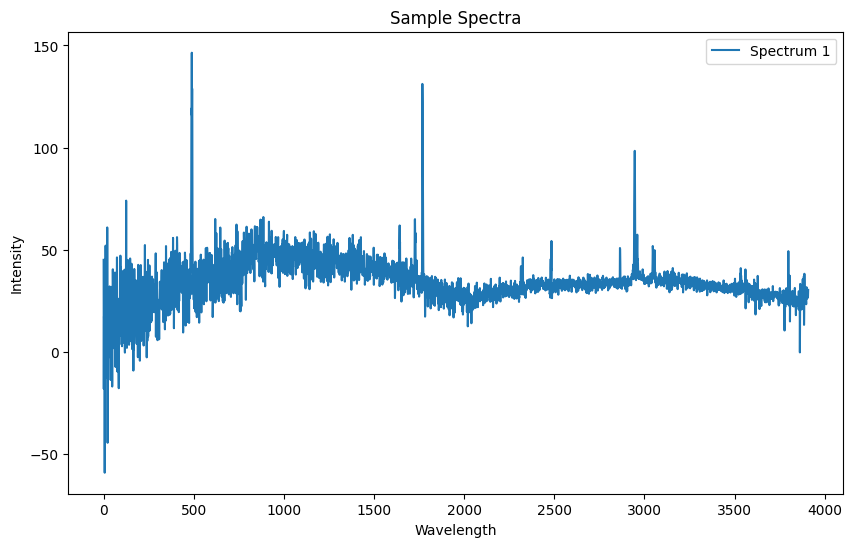

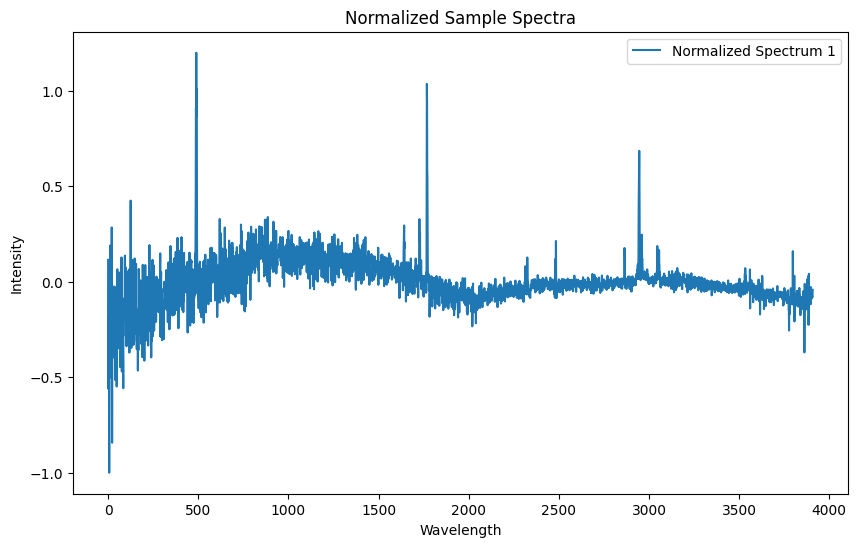

In [7]:
# Plot sample spectra to check if everything is goo
plot_sample_spectra(file_list, num_samples=1)

## Defining model

In [8]:
import tensorflow as tf

def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=(9,),
                   dense_units=128, 
                   dropout_rate=0.5,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4)

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [9]:
len_ = 3748

# Now use these datasets to train the model
convnet_model = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)))

convnet_model.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3738, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1869, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 934, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 934, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 467, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 467, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 233, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 233, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 116, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 58, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 29, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,388 (4.82 MB)

 Trainable params: 1,264,388 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

## Create datasets

In [10]:
len_ = 3748
max_workers_ = 1024

def load_single_spectrum(file_path, target_length=len_):
    """Load and normalize a single spectrum from a FITS file, truncating or padding to target_length."""
    try:
        with fits.open(file_path) as hdul:
            spectra = hdul[0].data[0]
            spectra = normalize_spectra(spectra)
            
            # Truncate or pad spectra to ensure uniform length
            if len(spectra) > target_length:
                spectra = spectra[:target_length]  # Truncate
            else:
                spectra = np.pad(spectra, (0, max(0, target_length - len(spectra))), mode='constant')  # Pad with zeros
            
            return spectra
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if there's an error

def load_all_spectra_parallel(file_list, target_length=len_, max_workers=max_workers_):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    spectra_data = []
    
    with ThreadPoolExecutor(max_workers=max_workers_) as executor:
        # Use ThreadPoolExecutor to parallelize the loading of FITS files
        results = list(tqdm(executor.map(lambda f: load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))

    # Filter out None results (in case any files failed to load)
    spectra_data = [spectrum for spectrum in results if spectrum is not None]

    return np.array(spectra_data)

# Example usage:
file_list, labels = generate_file_list()

# Load spectra data in parallel using multiple threads
# Set target length for uniform spectra length (adjust the target_length as needed)
#spectra_data = load_all_spectra_parallel(file_list, target_length=len_, max_workers=max_workers_)

# Convert labels to numpy array
labels = np.array(labels)

# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Continue with creating train/validation datasets
train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)

# Load training and validation spectra in parallel
train_spectra = load_all_spectra_parallel(train_files, target_length=len_, max_workers=max_workers_)
val_spectra = load_all_spectra_parallel(val_files, target_length=len_, max_workers=max_workers_)


Gathering FITS files...
Total spectra files collected: 165948


Loading spectra: 100%|██████████| 33189/33189 [01:54<00:00, 289.44it/s] 
2024-09-26 10:23:08.860953: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1990322928 exceeds 10% of free system memory.
2024-09-26 10:23:10.809466: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1990322928 exceeds 10% of free system memory.


## Making model

## Train (NAN removed after)

In [19]:
import numpy as np

# Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
train_spectraa = np.array(train_spectra[10:, :])
train_labelsa = np.array(train_labels[10:])
del train_spectra, train_labels
gc.collect()
val_spectraa = np.array(val_spectra[10:, :])
val_labelsa = np.array(val_labels[10:])
del val_spectra, val_labels, file_list, labels
gc.collect()

# Remove nan values from the spectra
mask_train = ~np.isnan(train_spectraa).any(axis=1)
train_spectranan = train_spectraa[mask_train]
train_labelsnan = train_labelsa[mask_train]

del train_spectraa, train_labelsa, mask_train
gc.collect()

mask_val = ~np.isnan(val_spectraa).any(axis=1)
val_spectranan = val_spectraa[mask_val]
val_labelsnan = val_labelsa[mask_val]

del val_spectraa, val_labelsa, mask_val
gc.collect()

# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

del train_spectranan, train_labelsnan
gc.collect()


NameError: name 'train_spectra' is not defined

# Training, note it is incremental and does not restart

In [12]:
# Function to train the model with the training and validation datasets
def train_convnet(model, train_dataset, val_dataset, epochs=10, batch_size=32):
    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size)
    
    return history

In [ ]:
def train_convnet_many_times(model, train_dataset, val_dataset, epochs_per_run=1, batch_size=32, num_runs=10):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, train_dataset, val_dataset, epochs=epochs_per_run , batch_size=batch_size)
        histories.append(history)
    return histories

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Function to train the model with the training and validation datasets
def train_convnet(model, train_dataset, val_dataset, epochs=10, batch_size=32, patience=7):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history


In [14]:
history = train_convnet(convnet_model, train_dataset, val_dataset, epochs=15, batch_size=32)

Epoch 1/15


2024-09-26 10:23:23.872729: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1990173008 exceeds 10% of free system memory.
I0000 00:00:1727342607.097180   40621 service.cc:146] XLA service 0x7f5410002a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727342607.097285   40621 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-09-26 10:23:27.167577: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-26 10:23:27.542979: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   7/4149 ━━━━━━━━━━━━━━━━━━━━ 1:27 21ms/step - accuracy: 0.4558 - loss: 1.3750 

I0000 00:00:1727342613.288326   40621 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4149/4149 ━━━━━━━━━━━━━━━━━━━━ 112s 25ms/step - accuracy: 0.6756 - loss: 0.6948 - val_accuracy: 0.7661 - val_loss: 0.4996
Epoch 2/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 101s 24ms/step - accuracy: 0.7747 - loss: 0.4795 - val_accuracy: 0.8046 - val_loss: 0.4218
Epoch 3/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 100s 24ms/step - accuracy: 0.8072 - loss: 0.4301 - val_accuracy: 0.8180 - val_loss: 0.3975
Epoch 4/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 101s 24ms/step - accuracy: 0.8164 - loss: 0.4031 - val_accuracy: 0.8192 - val_loss: 0.3889
Epoch 5/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 100s 24ms/step - accuracy: 0.8258 - loss: 0.3869 - val_accuracy: 0.8277 - val_loss: 0.3790
Epoch 6/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 97s 23ms/step - accuracy: 0.8301 - loss: 0.3714 - val_accuracy: 0.8315 - val_loss: 0.3725
Epoch 7/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 98s 23ms/step - accuracy: 0.8391 - loss: 0.3591 - val_accuracy: 0.8371 - val_loss: 0.3641
Epoch 8/15
4149/4149 ━━━━━━━━━━━━━━━━━━━━ 99s 24ms/step - accuracy: 0.8439 - loss:

In [ ]:
# Save the model
convnet_model.save('convnet_model_v3')

## metrics

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
print(tf.config.list_physical_devices('GPU'))

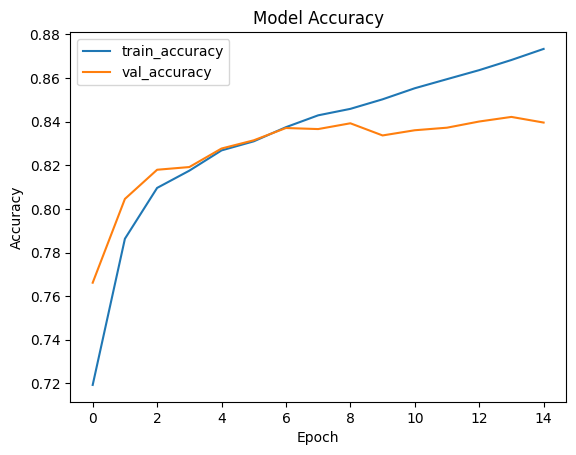

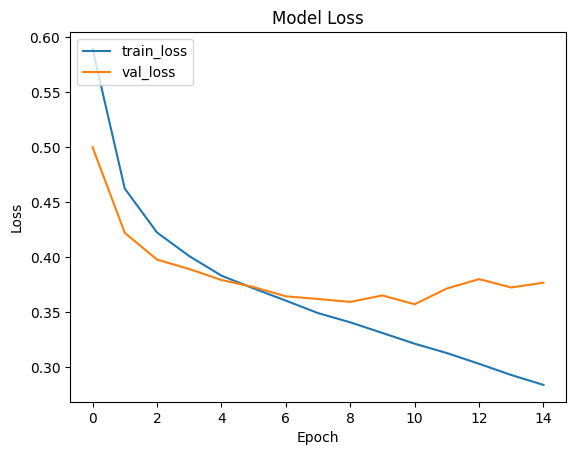

In [16]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [18]:


# Make predictions on the validation/test dataset
val_predictions = convnet_model.predict(val_spectranan)

# Convert the predictions to class labels (assuming one-hot encoding)
predicted_labels = np.argmax(val_predictions, axis=1)

# Convert true labels if they are in one-hot encoded format
true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric


# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report for more metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'val_spectranan' is not defined

In [17]:
# Check class distribution
unique, counts = np.unique(true_labels, return_counts=True)
print(dict(zip(unique, counts)))


NameError: name 'true_labels' is not defined